# imports

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import json
import re
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
project_path = '/content/drive/MyDrive/Colab Notebooks/PatternMining'

# Load dataset

In [34]:
data = pd.read_csv(f'{project_path}/datasets/data_processed.csv')

# Frequent Pattern Extraction

In [35]:
data.drop(columns=['img', 'title', 'Processed_title', 'Stemmed_title', 'Lemmatized_title', 'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres', 'score'], inplace=True)

## Distribute Numerical values

In [37]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for column in numeric_columns:
    data[column] = pd.cut(data[column], bins=3, labels=['low', 'medium', 'high'])

print(data.head())

                  genres                product rating user score  \
0        Auto Racing Sim          Rated E For Everyone       high   
1        Auto Racing Sim          Rated E For Everyone       high   
2            Western RPG              Rated T For Teen       high   
3  Vertical Shoot-'Em-Up  Rated E +10 For Everyone +10     medium   
4                    FPS              Rated T For Teen     medium   

  user ratings count platform metascore metascore_count  \
0                low       XB        59             low   
1                low       GC        56             low   
2                low       PC        63             low   
3                low       NS        61             low   
4                low       PC        70             low   

                 publisher            developer total_sales na_sales  \
0  Gathering of Developers     Terminal Reality         low   medium   
1                 VU Games     Terminal Reality         low      low   
2             

## Encoding

In [38]:
# Convert categorical data to one-hot encoding
data_one_hot = pd.get_dummies(data)

# Display the one-hot encoded dataframe to check the changes
print(data_one_hot.head())


   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  genres_3D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_4X Strategy  genres_Action  genres_Action Adventure  \
0               False          False                    False   
1               False       

## Frequent item-sets

In [39]:
# Perform frequent pattern extraction using the apriori algorithm
min_support_threshold = 0.9
frequent_itemsets = apriori(data_one_hot, min_support=min_support_threshold, use_colnames=True)
print(frequent_itemsets)

    support                                           itemsets
0  0.999907                           (user ratings count_low)
1  0.932099                              (metascore_count_low)
2  0.999907                                  (total score_low)
3  0.932099      (user ratings count_low, metascore_count_low)
4  0.999907          (user ratings count_low, total score_low)
5  0.932099             (total score_low, metascore_count_low)
6  0.932099  (user ratings count_low, total score_low, meta...


## Association Rules

In [40]:
# Generate association rules with minimum confidence threshold
min_confidence_threshold = 0.9  # Adjust as per your dataset and requirements
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence_threshold)

# Display the rules
print(rules)

                                      antecedents  \
0                        (user ratings count_low)   
1                           (metascore_count_low)   
2                        (user ratings count_low)   
3                               (total score_low)   
4                               (total score_low)   
5                           (metascore_count_low)   
6       (user ratings count_low, total score_low)   
7   (user ratings count_low, metascore_count_low)   
8          (total score_low, metascore_count_low)   
9                        (user ratings count_low)   
10                              (total score_low)   
11                          (metascore_count_low)   

                                      consequents  antecedent support  \
0                           (metascore_count_low)            0.999907   
1                        (user ratings count_low)            0.932099   
2                               (total score_low)            0.999907   
3                 

# Clustering

In [218]:
# ['title', 'genres', 'product rating', 'user score', 'user ratings count',
#        'platform', 'metascore', 'metascore_count', 'img', 'publisher',
#        'developer', 'total_sales', 'na_sales', 'pal_sales', 'other_sales',
#        'release date', 'last_update', 'total score', 'score',
#        'Processed_title', 'Stemmed_title', 'Lemmatized_title',
#        'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres']

data.drop(columns=['title', 'user ratings count',
        'metascore_count', 'img',
       'developer','release date', 'last_update', 'total score', 'score',
       'Processed_title', 'Stemmed_title', 'Lemmatized_title',
       'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres'], inplace=True)

## Numerical & Categorical Separation

In [219]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['user score', 'total_sales', 'na_sales', 'pal_sales', 'other_sales']
Categorical columns: ['genres', 'product rating', 'platform', 'metascore', 'publisher']


## Encode Categorical Cols

In [220]:
# One-hot encode categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Display the first few rows of the encoded DataFrame
print(data_encoded.head())


   user score  total_sales  na_sales  pal_sales  other_sales  \
0      6.9606       0.1181    0.0886     0.0246       0.0049   
1      6.9606       0.0689    0.0541     0.0148       0.0000   
2      7.5000       0.2563    0.1518     0.0930       0.0115   
3      6.2000       0.2563    0.1518     0.0930       0.0115   
4      6.6000       0.2563    0.1518     0.0930       0.0115   

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  ...  publisher_evoline srl  \
0                  False               False  ...                  False   
1                  False               Fal

## Scale Numerical Cols

In [221]:
# Standardize the numerical data
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_columns])
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_columns)

# Concatenate scaled numerical data with encoded categorical data
processed_data = pd.concat([scaled_numerical_df, data_encoded.drop(columns=numerical_columns)], axis=1)

# Display the first few rows of the processed DataFrame
print(processed_data.head())


   user score  total_sales  na_sales  pal_sales  other_sales  \
0    0.023124    -0.950788 -0.624495  -1.285392    -1.239778   
1    0.023124    -1.507935 -1.277619  -1.559966    -2.433346   
2    0.429625     0.614208  0.571952   0.631018     0.367886   
3   -0.550078     0.614208  0.571952   0.631018     0.367886   
4   -0.248631     0.614208  0.571952   0.631018     0.367886   

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  ...  publisher_evoline srl  \
0                  False               False  ...                  False   
1                  False               Fal

## Kmeans

In [241]:
# Let's assume the optimal number of clusters found is 3
optimal_k = 10

# Apply k-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(processed_data)

# Add the cluster labels to the original DataFrame
data['Cluster'] = clusters

# Display the first few rows with cluster labels
print(data.head())


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


            genres                product rating  user score platform  \
0  Auto Racing Sim          Rated E For Everyone      6.9606       XB   
1  Auto Racing Sim          Rated E For Everyone      6.9606       GC   
2            Other              Rated T For Teen      7.5000       PC   
3            Other  Rated E +10 For Everyone +10      6.2000       NS   
4              FPS              Rated T For Teen      6.6000       PC   

  metascore publisher  total_sales  na_sales  pal_sales  other_sales  Cluster  
0     Other     Other       0.1181    0.0886     0.0246       0.0049        4  
1     Other     Other       0.0689    0.0541     0.0148       0.0000        8  
2     Other     Other       0.2563    0.1518     0.0930       0.0115        3  
3     Other     Other       0.2563    0.1518     0.0930       0.0115        7  
4     Other     Other       0.2563    0.1518     0.0930       0.0115        3  


### TSNE visualization

In [243]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(processed_data)
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis')
plt.title('t-SNE - Clusters Visualization')
plt.show()


KeyboardInterrupt: 

### PCA visualization

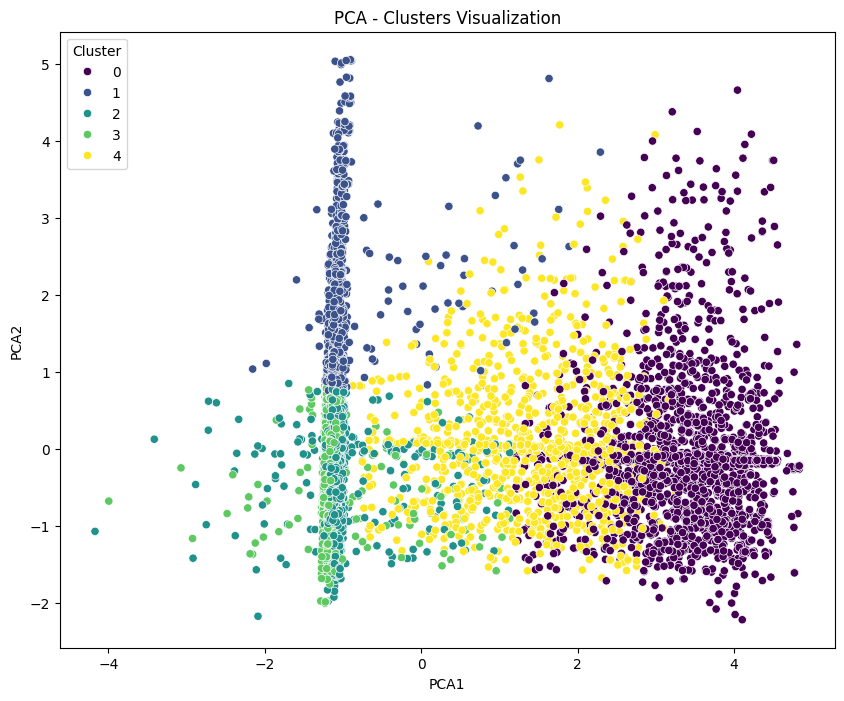

In [238]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Visualize the PCA-reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA - Clusters Visualization')
plt.show()


### Descriptive statistics

In [230]:
cluster_descriptive_stats = data.groupby('Cluster').describe()
print(cluster_descriptive_stats)


        user score                                                     \
             count      mean       std  min     25%     50%  75%  max   
Cluster                                                                 
0           2033.0  6.868400  1.277313  0.5  6.6000  6.9606  7.6  9.7   
1           1327.0  4.647400  1.205545  0.3  4.0000  5.0000  5.5  6.0   
2           3411.0  7.441509  0.749360  5.9  6.9606  7.4000  8.0  9.8   
3           2933.0  7.432656  0.765020  5.9  6.9000  7.4000  8.0  9.6   
4           1047.0  6.867245  1.196405  1.5  6.3000  6.9606  7.7  9.1   

        total_sales            ... pal_sales         other_sales            \
              count      mean  ...       75%     max       count      mean   
Cluster                        ...                                           
0            2033.0  0.049972  ...    0.0148  0.1033      2033.0  0.002565   
1            1327.0  0.253347  ...    0.0930  0.1722      1327.0  0.011558   
2            3411.0  0.25

### Feature Distribution

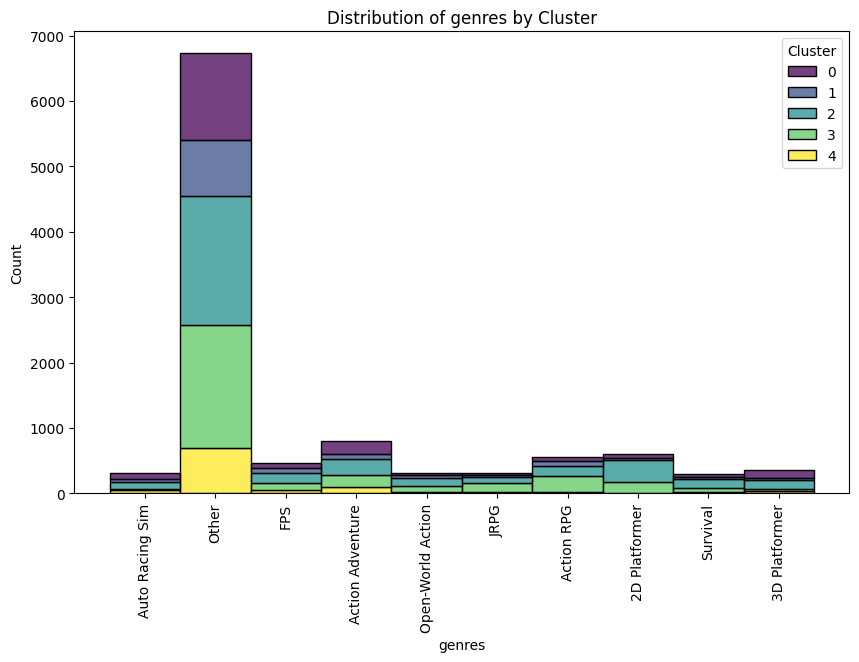

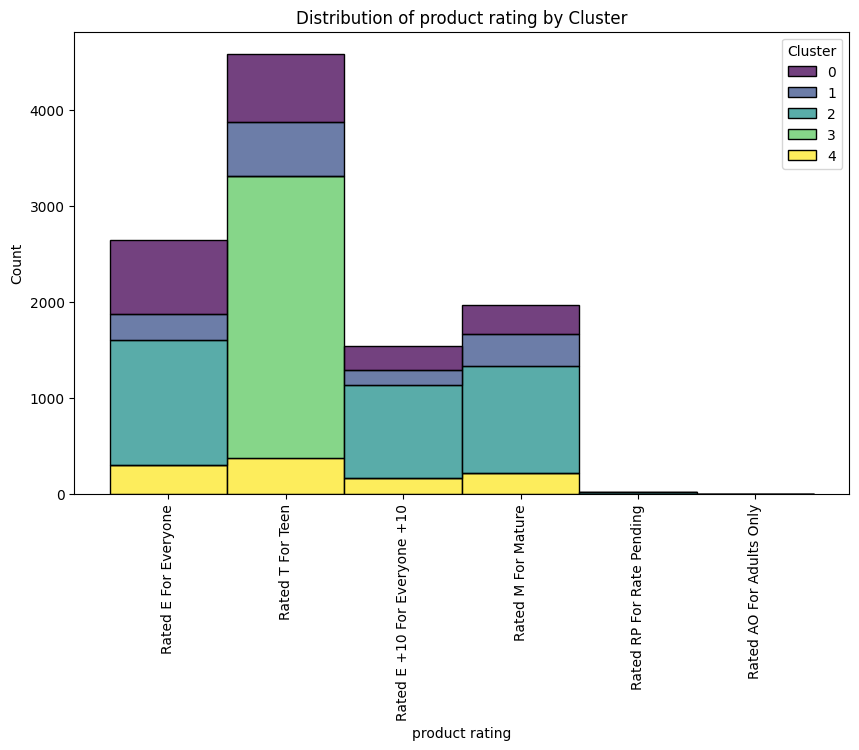

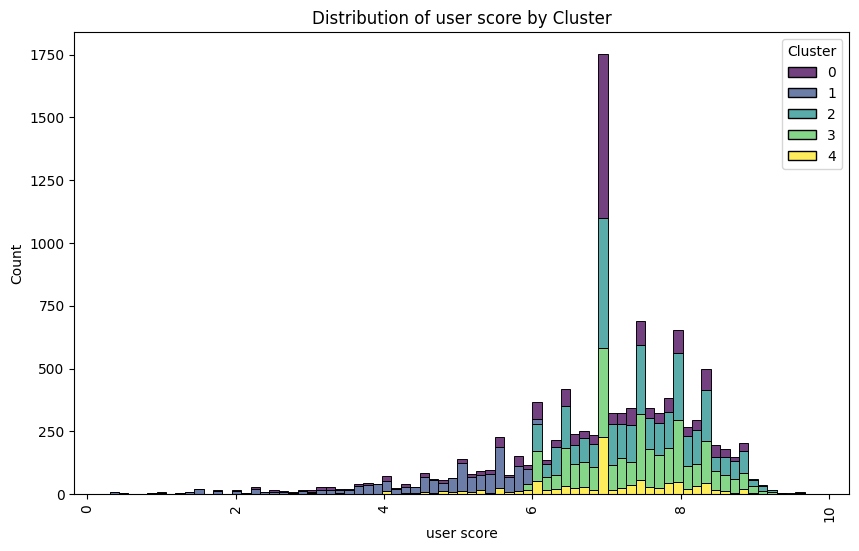

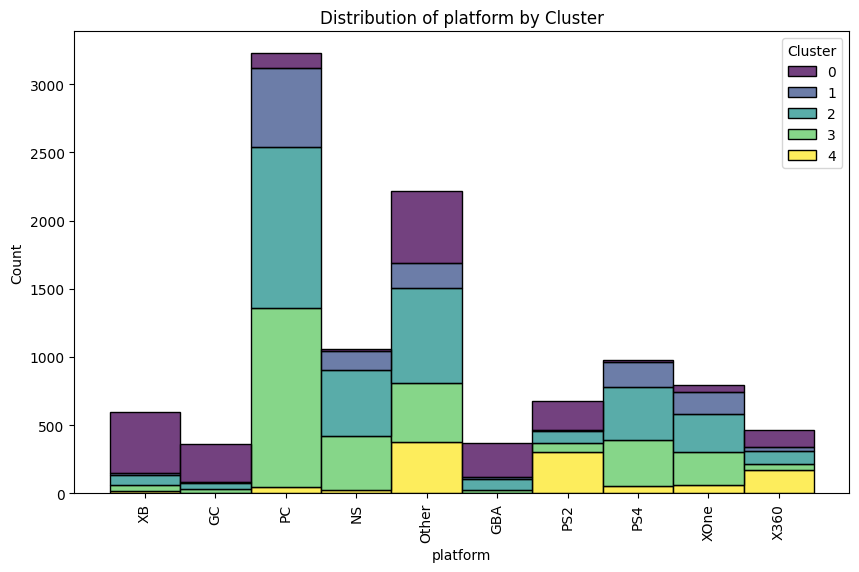

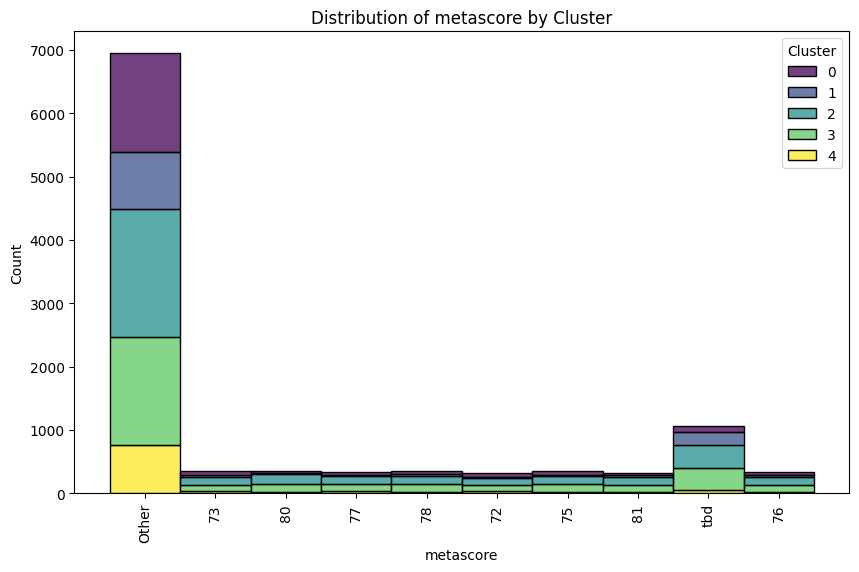

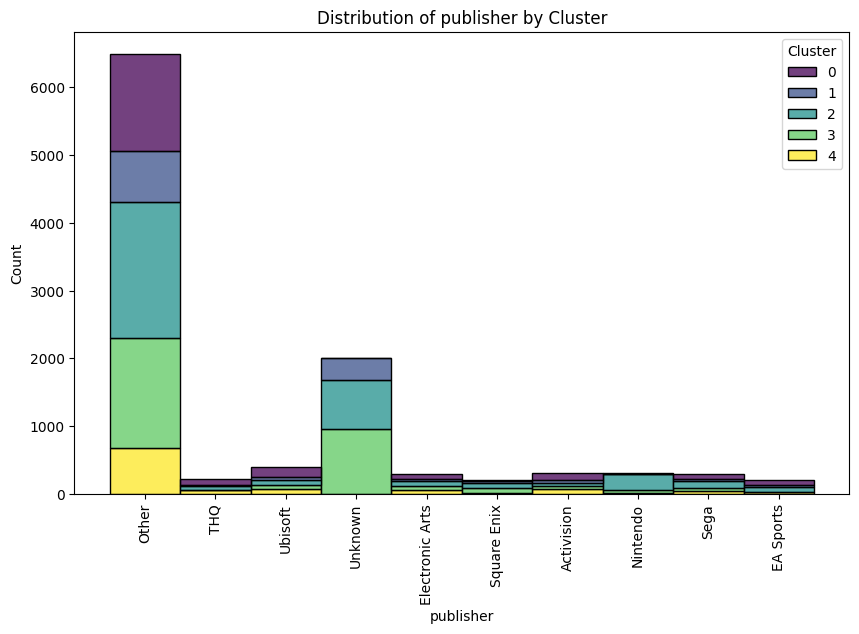

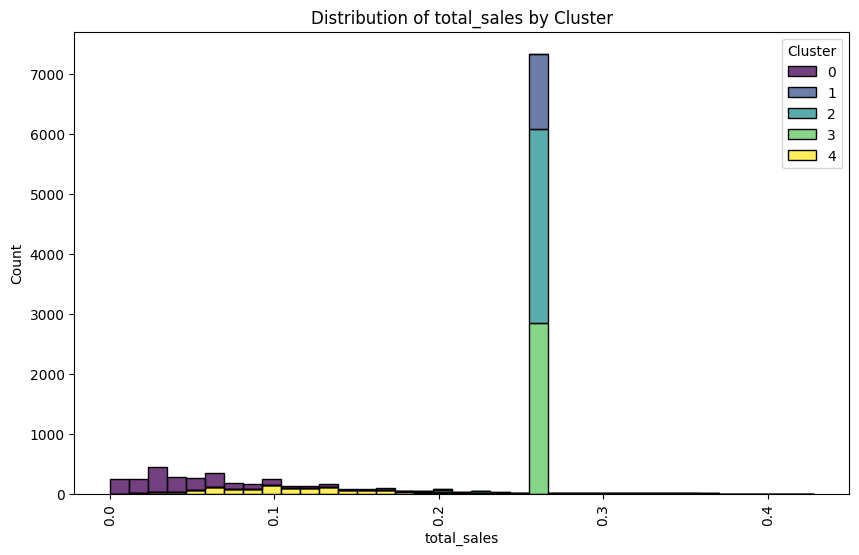

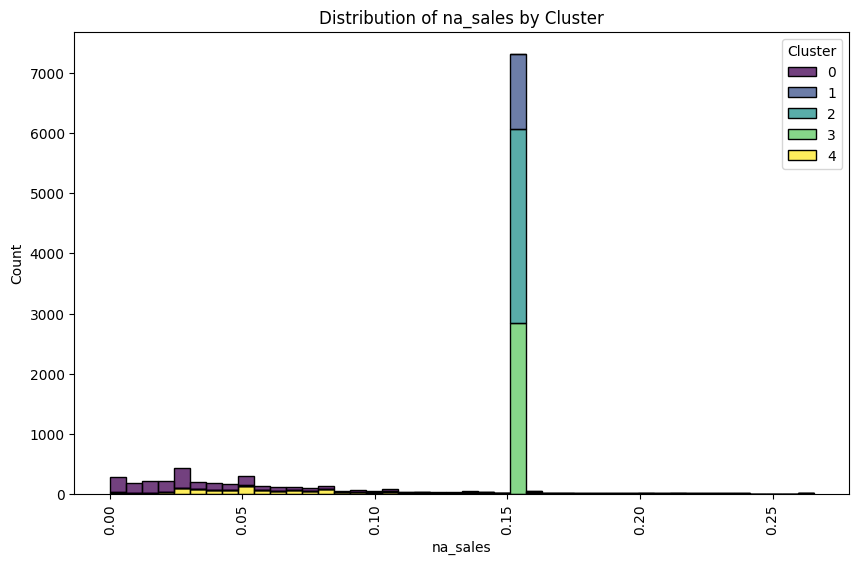

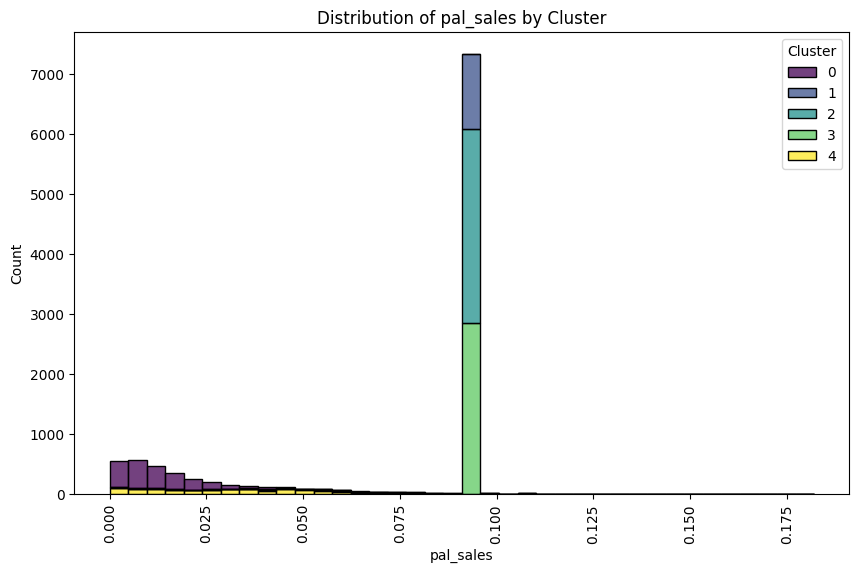

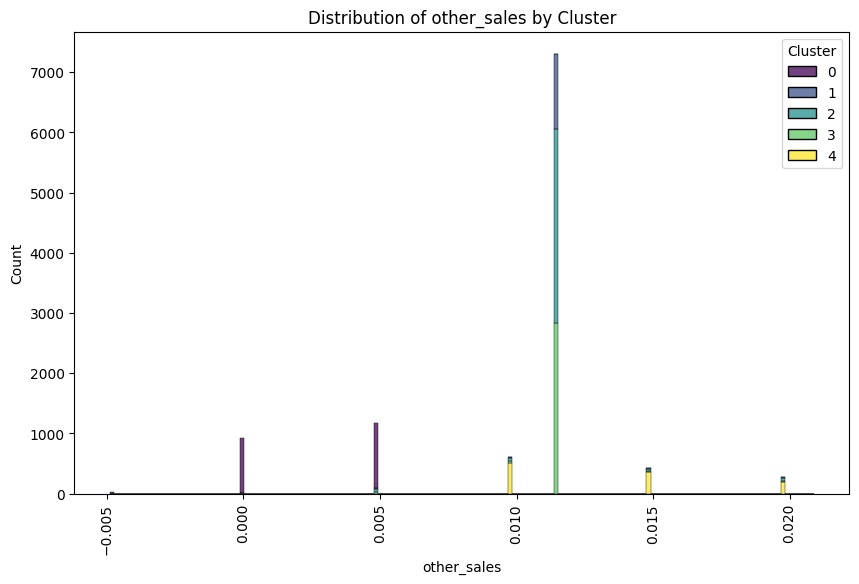

In [237]:
# Plot the distribution of each feature within each cluster
for column in data.columns:
    if column != 'Cluster':
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=column, hue='Cluster', multiple='stack', palette='viridis')
        plt.title(f'Distribution of {column} by Cluster')
        plt.xticks(rotation=90)  # Rotate x-axis labels
        plt.show()


### Feature-Feature plt

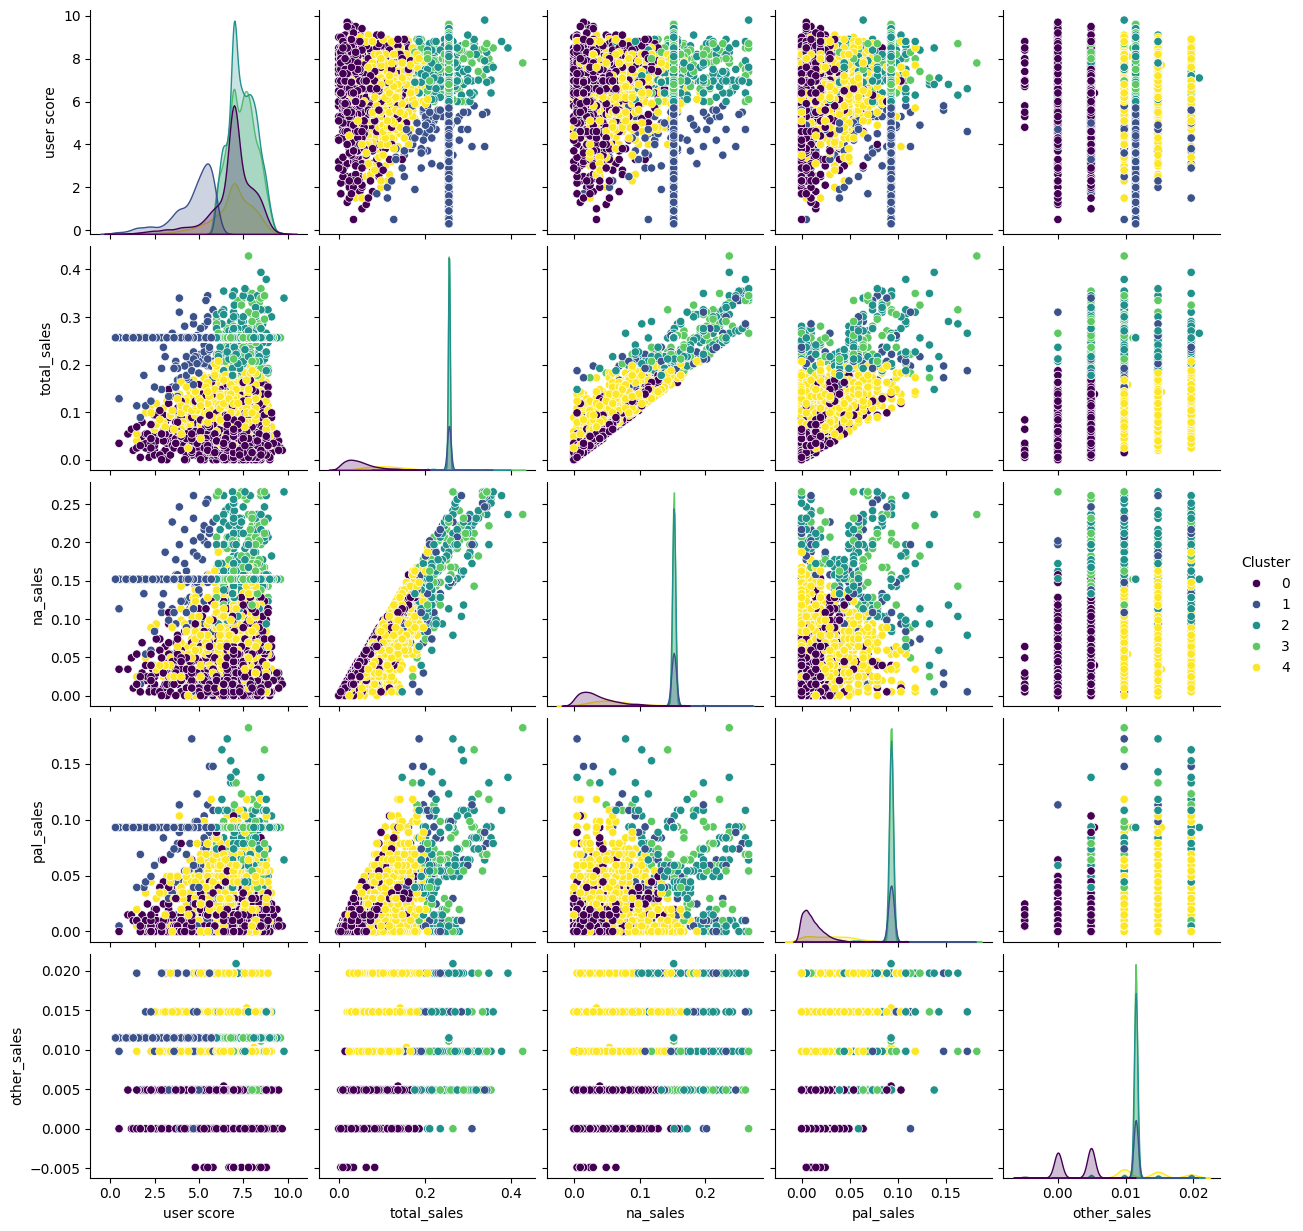

In [239]:
# Use pair plots to visualize relationships between features within each cluster
sns.pairplot(data, hue='Cluster', palette='viridis')
plt.show()


# other

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

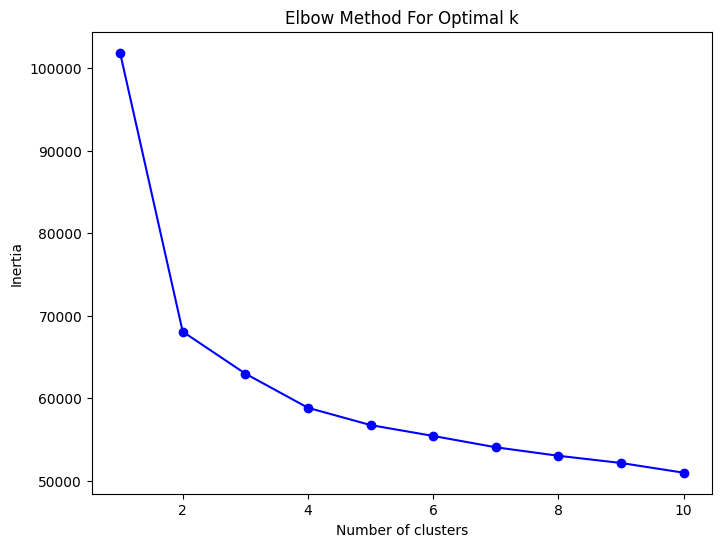

In [240]:
# Using the elbow method to find the optimal number of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(processed_data)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()
